# Data exploration

This notebook is used to explore the data and to get a better understanding of the data.

### Firstly we will visualize the kind of data we have. 
### We will use the [Pandas](https://pandas.pydata.org/) library and [matplotlib](https://matplotlib.org/) to visualize the data.

In [3]:
# Importing libraries

from imblearn.over_sampling import SMOTE
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os


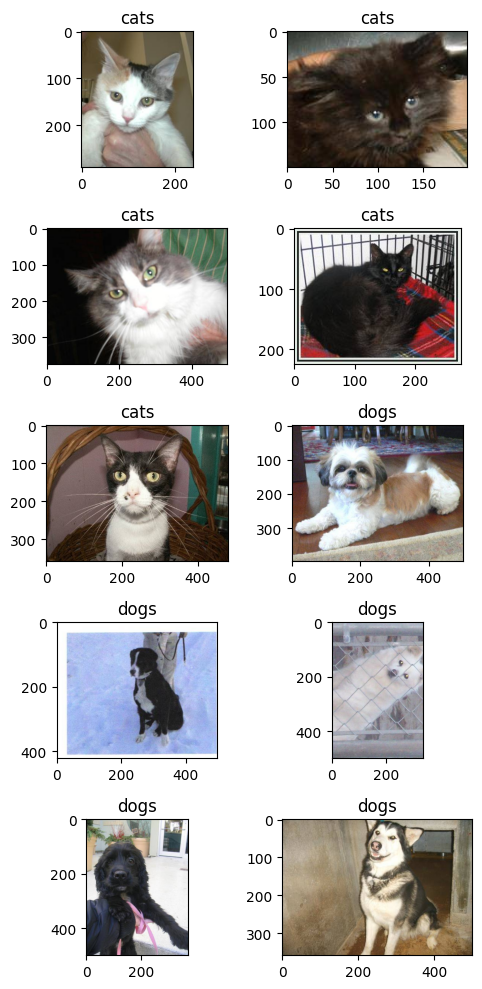

In [5]:
# Define paths to training and test sets
classes = ["cats", "dogs"]
data_dir = "../dataset"
train_dir = os.path.join(data_dir, "training_set")
test_dir = os.path.join(data_dir, "test_set")

# Display sample images
num_samples = 5
plt.figure(figsize=(num_samples, 10), tight_layout=True)
for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    random_samples = random.sample(os.listdir(class_path), num_samples)
    for j, sample in enumerate(random_samples):
        img = plt.imread(os.path.join(class_path, sample))
        plt.subplot(num_samples, len(classes), i * num_samples + j + 1)
        plt.imshow(img)
        plt.title(class_name)
plt.tight_layout()
plt.show()


### The training data is split into training and validation data. We will visualize the class distribution.

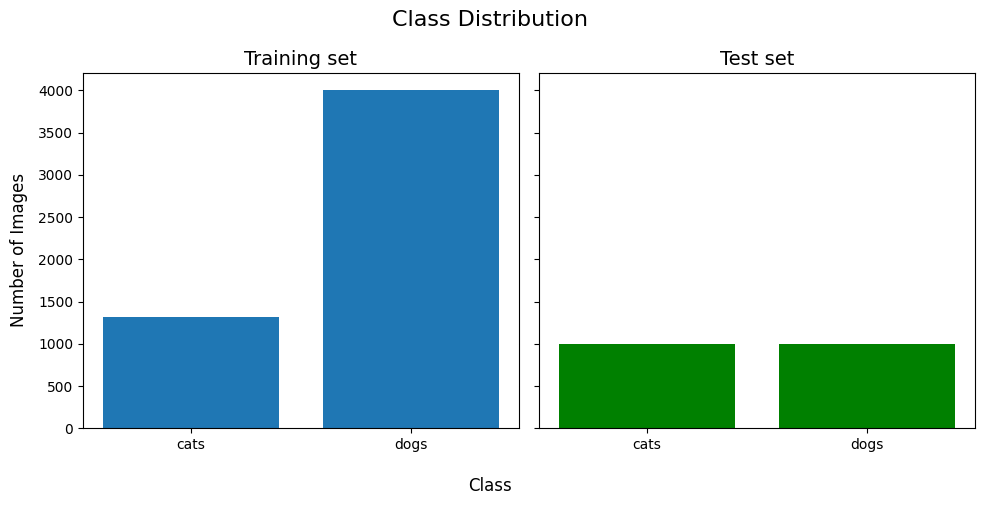

In [6]:
# Count the number of images in each class in the training set
class_counts_train = {}
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    class_counts_train[class_name] = num_images

# Count the number of images in each class in the test set
class_counts_test = {}
for class_name in classes:
    class_path = os.path.join(test_dir, class_name)
    num_images = len(os.listdir(class_path))
    class_counts_test[class_name] = num_images


# Visualize class distribution for training set
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True)
fig.suptitle("Class Distribution", fontsize=16)
fig.supxlabel("Class", fontsize=12)
fig.supylabel("Number of Images", fontsize=12)
axs[0].bar(class_counts_train.keys(), class_counts_train.values())
axs[0].set_title("Training set", fontsize=14)
axs[1].bar(class_counts_test.keys(), class_counts_test.values(), color="green")
axs[1].set_title("Test set", fontsize=14)
plt.show()    


### Creating model for training and validation data

In [54]:
import torchvision

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Load pretrained ResNet-18 model
model = torchvision.models.resnet18().to(device)

# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Loss functions specified in the torch.nn package
loss_fn = torch.nn.CrossEntropyLoss()

Using mps device


In [55]:

from torchvision import transforms

trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
training_set = torchvision.datasets.ImageFolder(
    "../dataset/training_set/", 
    transform=trans
)
test_set = torchvision.datasets.ImageFolder(
    "../dataset/test_set/", 
    transform=trans
)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


In [57]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [60]:
# training loop
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.466384  [   64/ 5317]
Test Error: 
 Accuracy: 55.4%, Avg loss: 0.818080 

Epoch 2
-------------------------------
loss: 0.417034  [   64/ 5317]
Test Error: 
 Accuracy: 64.0%, Avg loss: 0.628182 

Epoch 3
-------------------------------
loss: 0.499138  [   64/ 5317]
Test Error: 
 Accuracy: 54.8%, Avg loss: 0.968161 

Epoch 4
-------------------------------
loss: 0.452035  [   64/ 5317]
Test Error: 
 Accuracy: 65.6%, Avg loss: 0.618952 

Epoch 5
-------------------------------
loss: 0.372644  [   64/ 5317]
Test Error: 
 Accuracy: 57.0%, Avg loss: 0.747106 

Done!
